# Brief introduction to parallel programming with Python

You've had brief introduction to computer architecture and should already know that (once you've exhausted algorithmic improvements and using efficient libraries such as NumPy) the main path to increased performance is parallelism --- i.e., exploiting the ability of your computer to do multiple things at once.

How many processors/cores/threads does your computer have?
* my laptop has 1 processor with 2 physical cores and supports a total of 4 (hyper)threads
* yours might have more cores
We routinely use both cores when working on the computer --- e.g., doing homework in the word processor while watching Netflix in the browser.

At SBU we have the SeaWulf supercomputer
* It contains over 165 computers (also called nodes) --- actually now over 250 nodes --- now over 350
* Each computer has 2 processors for a total of 28 cores and 56 threads per computer (which has 128 Gbyte memory)
* In total there are 4620 cores and 21 Tbyte memory --- actually now over 10K cores --- now nearly 20K

In addition to running faster we often need to use parallel computing to use more memory.
* There is one computer in SeaWulf that has 72 cores (144 threads) and 3Tbyte memory.  A fantastic machine for big data analytics.

Lots of standard packages can internally use parallelism.

Here we explore how to use parallel programming as a general purpose tool using all of the cores within a single computer.

There are two related concepts:
* concurrency --- two or more actions that can occur in any order, including at the same time.
  * `(a+b) + (c+d)` --- yes --- the operations in parenthesis are independent, but note the final (center) addition must be evaluated last.
  * `a + b*c` --- no --- you must evaluate the multiplication before the addition
* parallelism --- operations actually occur at the same time. This requires concurrency for correctness, and adds simultaneous execution for performance.
  * In HPC (high-performance computing), performance is treated with nearly the same level of concern as correctness.

Also, 
* asynchronous execution --- overlapped/interleaved execution of operations, e.g.,
  1. start loading a web page
  2. switch to another tab and start loading another web page
  3. drink coffee while waiting for one of the pages to finish loading
  4. read which ever page downloads first
* useful when individual operations may take a long time but don't necessarily consume a lot of computer time (e.g., waiting for network services, a human, etc.)


To begin, let's pick a problem to solve.

Do you remember Tim?   We were interested in computing the probability of him falling into a canal on the way home.

A simplified version of the problem is the following random process.  In 1D Tim is initially located at the origin.  I.e.,
$$y(0)=0$$
where $y(t)$ is his position as a function of time ($t$) or, equivalently, the number of steps.
Each step he takes is chosen from a uniform random distribution between $-1$ and $1$.  I.e.,
$$y(t+1) = y(t) + U[-1,1]$$
where $U[-1,1]$ denotes the random number.  

We want to answer the question:
* When (i.e., at what time or with how many steps) does Tim first reach distance $Y$ from the origin, and how does this time depend upon $Y$?
* This is called the first crossing time
* It is important in many applications including chemistry, electronics, biology, etc.
* It is interesting to also examine the time and/or probability of returning to the origin.
* Also interesting is how first crossing time and return probability change with the number of dimensions
  * Aside: In 1 and 2 dimensions, a random walker returns infinitely often, but in 3 and higher dimensions there are only a finite number of returns.  A rather mathy explanation is [here](http://math.uchicago.edu/~may/REU2018/REUPapers/Ombrellaro.pdf).

To do this we will write a function to run a single random walk and return the time (number of steps) taken to reach $Y$.

In [1]:
import random
def random_walk(Y):
    ''' Execute a random walk and return the number of steps to reach +/- Y'''
    y = 0.0
    n = 0
    while abs(y) < Y:
        y += (random.random()-0.5)*2.0
        n += 1
    return n

In [2]:
print(random_walk(10))
print(random_walk(10))
print(random_walk(10))
print(random_walk(10))

119
173
236
107


It's a random number!  Duh.  

So instead we need to compute the average (or expectation value) over many walks.

Write a function to average the number of steps needed over `Nsample` walks

In [3]:
import statistics
def mean_length(Y,Nsample=300):
    return statistics.mean([random_walk(Y) for i in range(Nsample)])

Run it for Y=10,20,100

In [4]:
mean_length(10)

304.8433333333333

In [5]:
mean_length(100)

30530.076666666668

In [6]:
mean_length(200)

122751.69

Wow ... as we increase Y it takes longer and longer.  It would be nice to make this calculation faster.

Let's write a program that given a list of Ys runs each calculation (task) in parallel and returns the result to us.

We will use the Python standard `multiprocessing` module.
* https://docs.python.org/dev/library/multiprocessing.html 

Specifically, we will be using the process pool. Imagine a pool of workers waiting for a manager to give them tasks to execute.  The manager (or main process) 
* passes data to each worker describe the work that needs doing
  * if there is a lot of data the overhead of passing data needs to be offset by the amount of work that needs doing
* takes the result as each worker finishes a task and gives more work
* once all the work is done sends the workers home (terminates the worker processes)

The processes clearly needs to know not just some data (in our case the value of $Y$) but also what code to execute.  Thus, they need access to your Python program.

[On Windows using slightly older versions of Python, parallelism did not work easily inside Jupyter notebook and some workarounds were necessary]

Quick aside to look at **functional programming** in Python using `map`, `filter` and `reduce`
* [builtin functions](https://docs.python.org/3/library/functions.html) for documentation on `map`, `filter` and `reduce`
* [tutorial-1](https://book.pythontips.com/en/latest/map_filter.html)
* [tutorial 2](https://realpython.com/python-map-function/)
* Note they return an iterable, so they can efficiently handle large (even unbounded) inputs
* It's really just `map` we need for now, but it's good to undersand all 3 tools.

These 3 basic elements were the intial foundation of the big data revolution
* How can you operate on (or even understand or reason about) data that needs hundreds of thousands of computers to store and manipulate?
* How can you reliably compute using hundreds of thousands of computers when something is always broken (because there's so many parts)?
* [Hadoop](https://hadoop.apache.org/)
  * Fairly quickly Hadoop was superseded by more sophisticated approaches
  * Basic map/reduce is very inefficient since it moves much more data than necessary (remember the H/W discussion --- moving data is the most expensive operation in money, time and energy)
  * It (specifically the Hadoop file system) was a "crude" software solution to a fairly easily solved hardware problem (reliable fast storage)
  * It did not address many data/computational needs

In [7]:
import random

values = [random.random()-0.5 for i in range(10)]  # Doesn't have to be a list --- any iterable
values2= [random.random()-0.5 for i in range(10)]
print(values)

# Filter
print("Filter 1")
for value in filter(lambda x: x>=0, values):
    print(value)

print("\nFilter 2")
positives = list(filter(lambda x: x>=0, values))
print(positives)

print("\nFilter 3")
positives = [value for value in filter(lambda x: x>=0, values)]
print(positives)

# Map
print("\nMap 1")
squares = list(map(lambda x: x**2, values))
print(squares)

print("\nMap 2")
sumsqs = list(map(lambda x, y: x**2 + y**2, values, values2))
print(sumsqs)

# Reduce
from functools import reduce
print("\nReduce 1")
sum1 = sum(values)
sum2 = reduce(lambda x, y: x+y, values)
print(sum1, sum2)

print("\nReduce 2")
product1 = reduce(lambda x, y: x*y, values)
product2 = 1
for value in values:
    product2 *= value
print(product1, product2)

[-0.09395407076080287, -0.465654933240777, 0.06123153171135698, 0.37388161721917257, -0.30407057338810506, 0.3841963196315822, -0.045513312180639476, 0.17557275973823594, 0.15403095297082225, -0.02235685544023014]
Filter 1
0.06123153171135698
0.37388161721917257
0.3841963196315822
0.17557275973823594
0.15403095297082225

Filter 2
[0.06123153171135698, 0.37388161721917257, 0.3841963196315822, 0.17557275973823594, 0.15403095297082225]

Filter 3
[0.06123153171135698, 0.37388161721917257, 0.3841963196315822, 0.17557275973823594, 0.15403095297082225]

Map 1
[0.008827367412525952, 0.21683451685147248, 0.0037493004757189153, 0.13978746369442388, 0.09245891360057099, 0.14760681201845285, 0.0020714615856523458, 0.030825793962100324, 0.023725534473099656, 0.000499828985175348]

Map 2
[0.06382710480444147, 0.24192864711593332, 0.2152229324416873, 0.21013850219333124, 0.16410463684200408, 0.18937995750579523, 0.02649023552044681, 0.09857414936258024, 0.042466384646352474, 0.045763255777852924]

Re

**First**, a simple example.  We will write a parallel program to compute the sine of each of a list of numbers --- we don't expect to see any speed up since there is so little work to do compared with the overhead of communication between manager and worker.


In [8]:
import math
import time
import multiprocessing as mp

# For use in a script
#if __name__ == "__main__":
#    mp.freeze_support() # usually only needed for older Pythons on windows
# and indent everything below to be protected by the if

NUM_WORKERS = 2

start_time = time.time()

with mp.Pool(processes=NUM_WORKERS) as pool:
    results = pool.map(math.sin, [0.1,0.2,0.3,-2.3,77.0])

end_time = time.time()   
print(results)

print("Time : %ssecs" % (end_time - start_time))

[0.09983341664682815, 0.19866933079506122, 0.29552020666133955, -0.7457052121767203, 0.9995201585807313]
Time : 0.04405641555786133secs


In [9]:
list(map(math.sin, [0.1,0.2,0.3,-2.3,77.0]))

[0.09983341664682815,
 0.19866933079506122,
 0.29552020666133955,
 -0.7457052121767203,
 0.9995201585807313]

**Global variables:** Remember again that each process has completely separate memory.  Therefore, any results must be returned by the tasks.  

Also, depending on your operating system and its method to create the new processes 
* you *may* or *may not* have access to *copies* of global variables defined in the main program, and
* even if you can access the global variables they may not have up-to-date values, and
* any changes made to global data will not be visible to other processes.

Best practices: 
* pass all necessary data in as arguments to the tasks, or
* initialize all global data before you create the first sub-process and after that ensure that any global data you want accessible to sub-processes is read-only.

**Global interpreter lock (GIL):**  Why are we using processes that do not (easily) share data?  Why not use threads?
* The most widely-used implementation of Python (CPython) is internally not thread safe
  - This means that critical data structures inside Python have not been designed to permit multiple threads to be accessing/modifying them simultaneously.
  - This is in part historical (Python pre-dates the widespread use of threads) and in part because in the current implementation no-one has found a way to make Python thread safe without making it much slower.
  - Work is in progress to address this, but it has already been going on for years.
* Thus, everytime your code enters the Python kernel it there is a global lock that ensures that only one thread is inside. 
* Thus, you cannot use Python threads for parallelism --- you can only use them for concurrency (e.g., to express asynchronous operations) but only one thread will be executing Python code at any one moment.
* You can call external routines (e.g., from NumPy or SciPy) that are implemented in a different language (e.g., C/C++) and they can use threads for parallelism as long as they do not call back into Python.


Python `with` statement
* https://effbot.org/zone/python-with-statement.htm
* https://www.geeksforgeeks.org/with-statement-in-python/
* https://preshing.com/20110920/the-python-with-statement-by-example/
* https://docs.python.org/3/reference/compound_stmts.html#the-with-statement
* https://realpython.com/python-with-statement/


In [10]:
try:
    file = open("allswell.txt")
    print("There are %d lines in the file." % len(file.readlines()))
    raise ValueError
    file.close()
except ValueError:
    print("Got ValueError")
print(file.closed)

print("")

try:
    file = open("allswell.txt")
    print("There are %d lines in the file." % len(file.readlines()))
    raise ValueError
except ValueError:
    print("Got ValueError")
finally:
    file.close()
print(file.closed)

print("")

try:
    with open("allswell.txt") as file:
        print("There are %d lines in the file." % len(file.readlines()))
        raise ValueError
except ValueError:
    print("Got ValueError")
print(file.closed)

print("")

with open("allswell.txt") as file:
        print("There are %d lines in the file." % len(file.readlines()))
        
print("")
print("There are %d lines in the file." % len(open("allswell.txt").readlines()))

There are 303 lines in the file.
Got ValueError
False

There are 303 lines in the file.
Got ValueError
True

There are 303 lines in the file.
Got ValueError
True

There are 303 lines in the file.

There are 303 lines in the file.


Some key ingredients if using a script rather than inline Jupyter notebook
* One process (the manager) will be running the script as its main program --- but we don't want all of the worker processes to execute the full script otherwise they too will make pools of workers that in turn will make more workers ... 
* So we need to use the `if __name__ == "__main__":` technique to stop unnecessary code from being executed
* For more details https://docs.python.org/dev/library/multiprocessing.html#multiprocessing-programming


Also, it *used* to be essential on Windows to have `mp.freeze_support` --- if needed it *must* be the first line after `if __name__ == "__main__":`
* `NUM_WORKERS` controls the number of processes we will create

OK, let's do the real problem.  Instead of executing `math.sin(value)` we want to execute `mean_length(Y)`
* modify the program to do this
* run it
* modify the number of workers --- how does the execution time vary?

Our list of Y values will be.

In [11]:
Ylist = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,150,150,150,150,150,150,150]
print(Ylist)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 150, 150, 150, 150, 150, 150, 150]


In [12]:
NUM_WORKERS = 10

start_time = time.time()

with mp.Pool(processes=NUM_WORKERS) as pool:
    results = pool.imap(mean_length, Ylist, 1) # 1 is the "chunksize"

end_time = time.time()   
print(results)

print("Time : %ssecs" % (end_time - start_time))

Time : 0.0377810001373291secs


In [13]:
Ylist.reverse()
print(Ylist)

[150, 150, 150, 150, 150, 150, 150, 150, 140, 130, 120, 110, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10]




This is what I get on my laptop (in a windows virtual machine with 2 cores)

* 1 worker  --- 30.0s
* 2 workers --- 18.5s
* 4 workers --- 16.6s

On my laptop under Linux
* 1 worker  --- 23.7s
* 2 workers --- 14.4s
* 4 workers --- 14.4s

On SeaWulf login node
* 1 worker  --- 32.0s
* 2 workers --- 15.7s
* 4 workers --- 9.6s
* 15 workers --- 5.9

Plot the results from the simulation

RuntimeError: matplotlib does not support generators as input

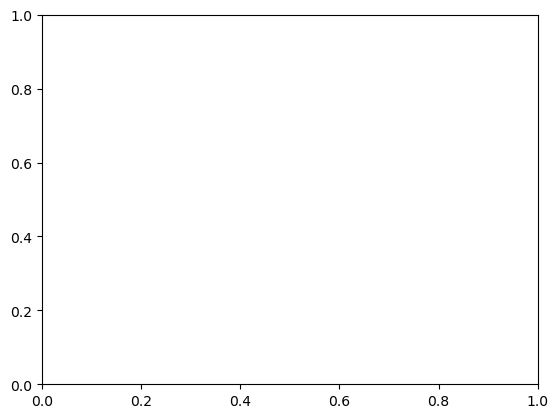

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(Ylist,results);

In [ ]:
Texact = [3*Y*Y for Y in Ylist]
plt.plot(Ylist,results,"r-", Ylist,Texact, "b-");

Can we make the calculation run even faster?
* order of evaluations
* chunking
* imap
* imap_unordered
* [map vs imap vs imap_unordered](https://stackoverflow.com/questions/26520781/multiprocessing-pool-whats-the-difference-between-map-async-and-imap)



What is the fastest we can run this calculation?
* Concept of **critical path** --- the sequence of computational steps that limit execution time.

Concept of performance model

### Amdahl's law. 

Imagine that it takes you $S$ seconds to get ready for work (pencil sharpening, making coffee, etc.), and that you have lots of independent tasks which need doing that together take $P$ seconds. Your execution time with just one worker (you) is approximately
$$ T(1) = S + P $$
But if you had $w$ workers your execution time could be
$$ T(w) = S + \frac{P}{w} $$

($P$ for parallel work; $S$ for sequential work)

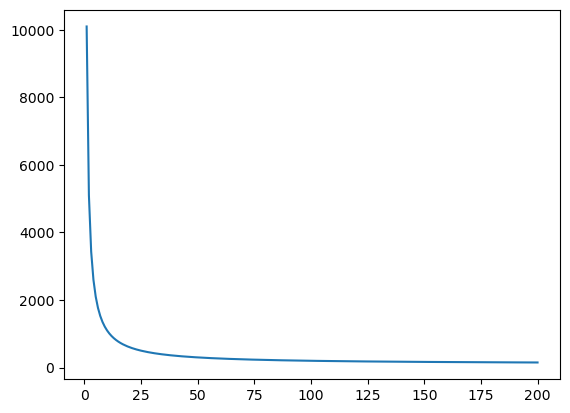

In [15]:
import numpy as np
S = 100
P = 10000
T = lambda w : S + P/w 
wlist = np.arange(1,201,1)
plt.plot(wlist, T(wlist));


How much faster can we make the calculation run?  I.e., if we had an infinite number of processors (I *want* that computer!!) how fast could it run? 

If we are using $w$ workers the speedup over using 1 worker is given by
$$ \text{speedup} = \frac{T(1)}{T(w)} = \frac{S+P}{S+P/w}  $$

If we have an infinite number of processors, then $P/w \rightarrow 0$ and
$$ \text{speedup} = \frac{S+P}{S} = 1 + \frac{P}{S} \approx \frac{P}{S}$$
where we assumed that $P \gg S$.

I.e., the speedup is limited by the ratio of parallel and sequential work.  

Amdahl's law is often said to be **cruel**.  If you want a 100-fold speedup, then only 1% of your work can be sequential.  If you want a 1,000,000-fold speedup, then only 0.0001% can be sequential.  Note that the largest computers in the world have $O(10^{18})$ parallelism!!!!!!!!!!

In our example above, with $S=100$ and $P=10000$ only a speedup of 100 is possible no matter how hard you try.

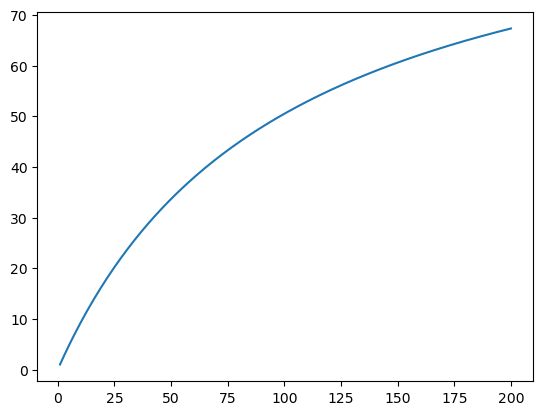

In [16]:
speedup = lambda w : (S+P)/(S+P/w)
plt.plot(wlist, speedup(wlist));

Ideal speedup is equal to the number of workers (processors) used.

The concept of efficiency is also useful.  Efficiency is defined as the ratio between the possible speedup and the ideal speedup.
$$\text{efficiency}(w) = \frac{\text{speedup}(w)}{w} = \frac{S+P}{wS+P}$$

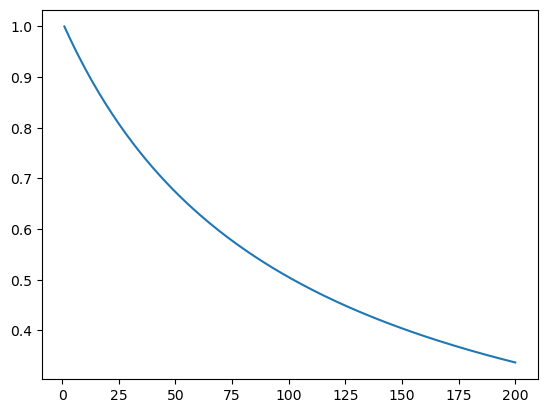

In [17]:
eff = lambda w : (S+P)/(w*S+P)
plt.plot(wlist,eff(wlist));

**Efficiency is very important** --- it translates into time, money spent for cloud services, energy consumed, $CO_2$ produced, etc.

Use the multiprocessing module to parallelize this Monte Carlo algorithm to compute $\pi$.
(https://www.geeksforgeeks.org/estimating-value-pi-using-monte-carlo/)
* It is basically computing the ratio of the area of a circle and a square
* Randomly sample points in a square
* Count if the point is inside the inscribed circle
  * Probability of being inside is the ratio of the areas $\pi r^2 / (4 r^2) = \pi/4$


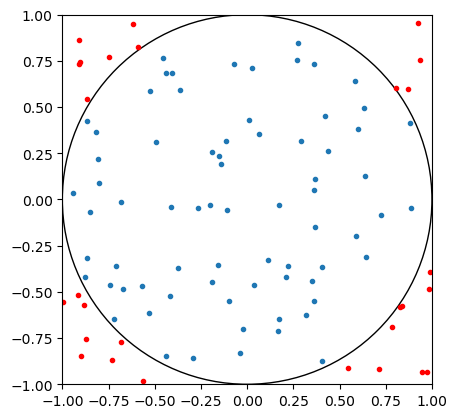

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np

x, y = 2*(np.random.random(100)-0.5), 2*(np.random.random(100)-0.5)
test = (x**2+y**2) < 1
xin, yin = x[test], y[test]
test = (x**2+y**2) >= 1
xout, yout = x[test], y[test]
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(xin, yin, ".")
plt.plot(xout, yout, "r.")
circle = patches.Circle((0,0),1,fill=False)
ax.add_patch(circle)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_aspect('equal', adjustable='box')


In [19]:
from random import random

def sample_one_point():
    x,y = random(),random()
    rsq = x*x + y*y
    if rsq <= 1:
        return 1
    else:
        return 0
    
def sample_one_batch(Npoint = 10000):
    sum = 0.0
    for i in range(Npoint):
        sum += sample_one_point()
    return 4*sum/Npoint

In [20]:
import time
import math
start = time.time()
sum = 0.0
sumsq = 0.0
Nbatch = 2000
for i in range(Nbatch):
    sample = sample_one_batch()
    sum += sample
    sumsq += sample**2
print("used %.2fs" % (time.time()-start))

PM = ""
mean = sum/Nbatch
meansq = sumsq/Nbatch
err = math.sqrt((meansq - mean**2)/Nbatch)
print("%.5f\u00B1%.5f" % (mean, err))

used 2.48s
3.14119±0.00036


In [21]:
# Implement parallel version here
NUM_WORKERS = 1

start_time = time.time()

values = [10000]*Nbatch

with mp.Pool(processes=NUM_WORKERS) as pool:
    results = pool.map(sample_one_batch, values, 1) # 1 is the "chunksize"

end_time = time.time()   
#print(results)

mean = statistics.mean(results)
err = statistics.stdev(results)
print("%.5f\u00B1%.5f" % (mean, err))
print("Time : %ssecs" % (end_time - start_time))


3.14161±0.01640
Time : 2.5947999954223633secs


In [22]:
dir(statistics)

['Counter',
 'Decimal',
 'Fraction',
 'NormalDist',
 'StatisticsError',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_coerce',
 '_convert',
 '_exact_ratio',
 '_fail_neg',
 '_find_lteq',
 '_find_rteq',
 '_isfinite',
 '_normal_dist_inv_cdf',
 '_ss',
 '_sum',
 'bisect_left',
 'bisect_right',
 'erf',
 'exp',
 'fabs',
 'fmean',
 'fsum',
 'geometric_mean',
 'groupby',
 'harmonic_mean',
 'hypot',
 'itemgetter',
 'log',
 'math',
 'mean',
 'median',
 'median_grouped',
 'median_high',
 'median_low',
 'mode',
 'multimode',
 'numbers',
 'pstdev',
 'pvariance',
 'quantiles',
 'random',
 'sqrt',
 'stdev',
 'tau',
 'variance']

Can you speedup up simulation of one random walk using parallelism or NumPy? 

No.  It is sequential and is not working on a vector of data.

But multiple, **independent** walks?  Yes.  We already used this when parallelizing the code.

To speed this up using NumPy requires moving the loop over *independent* samples inside the loop over steps and having a vector of samples.  

* This technique of promotion of data structures (scalar to vector) and possibly exchanging loop order is common when optimizing code.

E.g.,

In [23]:
def sample_one_batch(Npoint = 10000):
    x = np.random.random(Npoint)
    y = np.random.random(Npoint)
    rsq = x*x + y*y
    return 4*np.sum(rsq<=1)/Npoint

# Below here is the same timing code we used above
start = time.time()
sum = 0.0
sumsq = 0.0
Nbatch = 2000
for i in range(Nbatch):
    sample = sample_one_batch()
    sum += sample
    sumsq += sample**2
print("used %.2fs" % (time.time()-start))

PM = ""
mean = sum/Nbatch
meansq = sumsq/Nbatch
err = math.sqrt((meansq - mean**2)/Nbatch)
print("%.5f\u00B1%.5f" % (mean, err))

used 0.21s
3.14173±0.00036


I got about a 10x speedup switching from Python to NumPy ... what's the moral?  

Start close to home for optimization
1. Do less work by only computing what you need.
1. Use the best algorithm.
2. Efficient use of a single process (NumPy, external libraries, etc.) which translates to intra-process use of intra-processor parallelism.
3. Multi-thread (intra-process) and/or multi-process (inter-process) parallelism

## Comunicating processes

This is an advanced topic --- for most purposes try to use `map` or `imap` or `imap_unordered`.

For parallel programming, my rule-of-thumb is that for each factor of 10 speedup via parallelism there is about a factor of 2 increase in the programming cost
* Fugaku, recently the fastest computer in the world, has about 150,000 processors each with 48 cores
  * You will need 7.2 million threads to keep the entire machine busy!
* Programs that can use Fugaku efficiently are about 32-64x more expensive to write than programs for just one core (e.g., 1 month of programming versus 2-5 years).  
* Is your problem worth that effort?

Sometimes processes need to coordinate with each other and exchange data in order to parallelize a calculation.  Examples include:
* Client-server: A process is running in the background responding to requests --- e.g., database or web server
* Domain decomposition: E.g., computational fluid dynamcs simulation of the atmosphere
* Parallel linear algebra: operating on large matrices

**Example**: Use `process` and `pipe` from `multiprocessing` to create a server process connected via a pipe. It should forever
* receive a string, and 
* reply with the received value with "X" appended (e.g., if you received "hello" reply with "helloX")
* if the value is "stop" close the connection and return

Test the server by sending some test strings and then "stop".  The main process should also join the child process to clean up.


In [25]:
import multiprocessing as mp

def server(connection):
    print("server", __name__)
    while True:
        value = connection.recv()
        connection.send(value + "X")
        if value == "stop":
            break
    connection.close()

parent_conn, child_conn = mp.Pipe()
p = mp.Process(target=server, args=(child_conn,))
p.start()
for msg in ["a","fred","Who am I?", "stop"]:
    parent_conn.send(msg)
    print("sent", msg, "received", parent_conn.recv())
p.join()

server __main__
sent a received aX
sent fred received fredX
sent Who am I? received Who am I?X
sent stop received stopX


**Example:** Using `process` and `pipe` from `multiprocessing` write a program that 
* creates a "server" process connected to the main program with a pipe
* the server process *forever* receives values from the pipe
  * if the value is "hello" it replies "yes"
  * if the value is "bye" it replies "no", closes the pipe, and returns
* the main process 
  * sends "hello" 10 times to the server printing out the reply each time
  * sends "bye", checks that the reply is no, and then joins the process and exits


In [26]:
import multiprocessing as mp

def server(connection):
    while True:
        value = connection.recv()
        if value == "hello":
            connection.send("yes")
        else:
            connection.send("no")
            break
    connection.close()

parent_conn, child_conn = mp.Pipe()
p = mp.Process(target=server, args=(child_conn,))
p.start()
for msg in ["hello"]*10 + ["bye"]:
    parent_conn.send(msg)
    reply = parent_conn.recv()
    print("sent", msg, "received", reply)
    if msg == "bye":
        if reply != "no":
            raise ValueError
p.join()

sent hello received yes
sent hello received yes
sent hello received yes
sent hello received yes
sent hello received yes
sent hello received yes
sent hello received yes
sent hello received yes
sent hello received yes
sent hello received yes
sent bye received no


## Solution of partial differential equation in parallel

[Don't worry about the calculus --- it will vanish very soon.]

We will employ domain decomposition to solve the differential equation (eigen problem)
$$
 \frac{\partial^2 }{\partial x^2} f(x) = - f(x)
$$
on the domain $[0,\pi]$ with boundary conditions $f(0) = f(\pi) = 0$.  
* The solution is $f(x) = \alpha \sin(x)$ for any value of constant $\alpha$.

We will approximate the second derivative using the three-point stencil
$$
 f^{\prime \prime}(x) = \frac{\partial^2 f(x)}{\partial x^2} \approx \frac{1}{h^2} \left(f(x-h) - 2 f(x) + f(x+h) \right)
$$
where $h$ is the spacing between grid points in the $x$-dimension --- i.e., $x_i = i h$.  
* Note that to compute the second derivative at point $x_i$ we need the function values at $x_{i-1}$, $x_i$, and $x_{i+1}$.
* We also use the notation $f_i = f(x_i)$

Finally, we will update using Euler's method
$$
 f(x) \leftarrow f(x) + dt \frac{\partial^2 }{\partial x^2} f(x)
$$
for some small value $dt$ interpreted as a time step (in imaginary time if you are really interested).

No more calculus below here!

Thus, to solve the equation we 
1. Initialize $f_i = \text{guess}(x_i)$ with $x_i = i h$ for $i=0,\ldots,N-1$, and ensuring $f_0 = f_{N-1} = 0$.
2. Repeat until converged 
$$f(x_i) \leftarrow f(x_i) + dt \left(f(x_{i+1}) - 2 f(x_i) + f(x_{i-1}) \right) / h^2$$
(for the interior points $i=1,\ldots,N-2$ only, thus keeping $f_0 = f_{N-1} = 0$).


The next cell defines necessary parameters and functions

In [27]:
import math
import numpy as np

N = 51              # No. of points used --- need this to be odd
h = math.pi/(N-1)   # Element size
dt = 0.4*h**2       # Time step (must be less than (1/2)*h**2)
nstep = int(5.0/dt) # No. of steps required to converge
print("    N", N)
print("    h %.4f" % h)
print("   dt %.4f" %dt)
print("nstep", nstep)

# We'll solve for $f(x_i)$ at these points
x = np.linspace(0.0,math.pi,N)

def guess(x):
    return x*(math.pi-x) / (0.25*math.pi**2)

def diff2(f,h):
    ''' Estimates d2f/dx2 using 3 point stencil '''
    N = f.shape[0]
    df2 = np.zeros(N)
    df2[1:-1] = (f[2:]+f[:-2] - 2*f[1:-1])*h**-2
    #for i in range(1,N-1):
    #    df2[i] = (f[i+1] + f[i-1] - 2*f[i])/h**2
    return df2

def euler(f,dt,h):
    ''' Advances one time step using f(t+dt) = f(t) + dt * d2f/dx2 '''
    return f + dt * diff2(f,h)

def doplot(f, x):
    fac = math.sin(x[N//4])/f[N//4]
    f = fac*f # rescale to make comparison to exact easier 
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(x, f, 'b-', x, np.sin(x), 'k-')
    ax1.set_ylabel("f(x)")
    ax1.set_xlabel("x")
    ax2.plot(x, f-np.sin(x), 'r-')
    ax2.set_ylabel("error");


    N 51
    h 0.0628
   dt 0.0016
nstep 3166


**First,** solve across the entire domain $[0,\pi]$

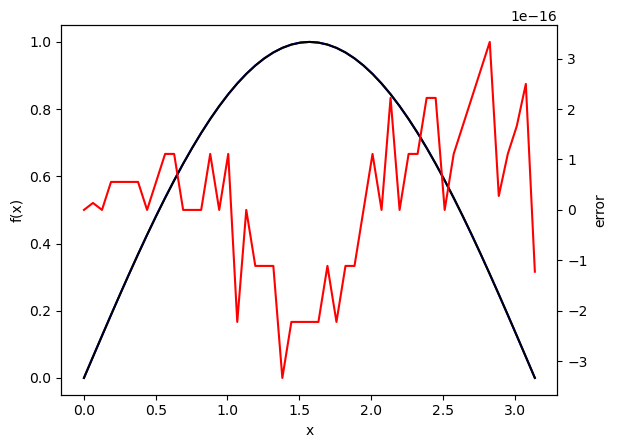

In [28]:
f = guess(x)
for step in range(nstep):
    f = euler(f,dt,h)
    
doplot(f, x)

**Second,** solve by dividing the domain into two $[0,\frac{\pi}{2}] + [\frac{\pi}{2}, \pi]$

The domain will be split *between* points $x_m$ and $x_{m+1}$, with $m=\frac{N-1}{2}$.  

But the solutions are coupled.  
* Using the formula for the second derivative
$$
 f^{\prime\prime}_m \approx \frac{1}{h^2} \left(f_{m-1} - 2 f_m + {\bf f_{m+1}} \right) \\
 f^{\prime\prime}_{m+1} \approx \frac{1}{h^2} \left({\bf f_{m}} - 2 f_{m+1} + f_{m+2} \right)
$$

* On the left, to compute the second derivative at point $x_{m}$ will need the value at $x_{m+1}$ --- but $f_{m+1}$ is being updated in the right domain
* On the right, to compute the second derivative at point $x_{m+1}$, we will need the value at $x_{m}$ --- but $f_m$ is being updated in the left domain
* Therefore, these *interior boundary* values must be exchanged every time step
* These values that must be exchanged are sometimes call "ghost cells" --- in the figure below they are greyed out

This figure illustrates what is going on

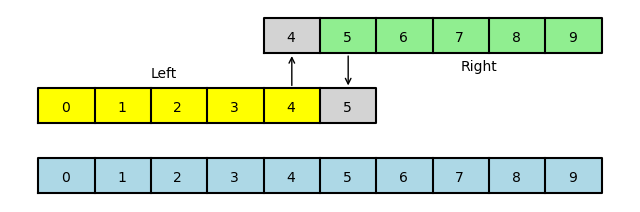

In [29]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
fig1 = plt.figure()
fig1.set_size_inches(8,2.5)
ax1 = fig1.add_subplot()
ax1.axis("off")
#ax1.text(-10, -2, "Start\n(0,0)")
#ax1.text(102, 28, "Island\n(X,Y)")
bar1 = patches.Rectangle((0,0), 100, 10, facecolor="lightblue")
ax1.add_patch(bar1)
ax1.plot([0, 0, 100, 100, 0], [0, 10, 10, 0, 0], "k-")

bar2 = patches.Rectangle((0,20), 60, 10, facecolor="yellow")
bar2a= patches.Rectangle((50,20), 10, 10, facecolor="lightgrey")
ax1.add_patch(bar2)
ax1.add_patch(bar2a)
ax1.plot([0, 0, 60, 60, 0], [20, 30, 30, 20, 20], "k-")
ax1.text(20, 33, "Left")

bar3 = patches.Rectangle((40,40), 60, 10, facecolor="lightgreen")
bar3a= patches.Rectangle((40,40), 10, 10, facecolor="lightgrey")
ax1.add_patch(bar3)
ax1.add_patch(bar3a)
ax1.plot([40, 40, 100, 100, 40], [40, 50, 50, 40, 40], "k-")
ax1.text(75, 35, "Right")


d = 100/10
for p in range(1,10):
    ax1.plot([p*d,p*d],[0,10], "k-")
for p in range(0,10):
    ax1.text((p+0.4)*d, 3.5, str(p))
    
for p in range(1,6):
    ax1.plot([p*d,p*d],[20,30], "k-")
    ax1.plot([p*d+40,p*d+40],[40,50], "k-")
for p in range(0,6):
    ax1.text((p+0.4)*d, 23.5, str(p))
    ax1.text((p+0.4)*d+40, 43.5, str(p+4))
    
ax1.annotate(text='', xy=(55,40), xytext=(55,30), arrowprops=dict(arrowstyle='<-',linestyle="-"))
ax1.annotate(text='', xy=(45,40), xytext=(45,30), arrowprops=dict(arrowstyle='->',linestyle="-"));


**But now --- the left and right sides can be updated in parallel!** 

How do we know this?  
* The updates of `fleft` and `fright` can be done in any order since they are operating on different arrays.

Let's demonstrate this with a small modification of the sequential code.

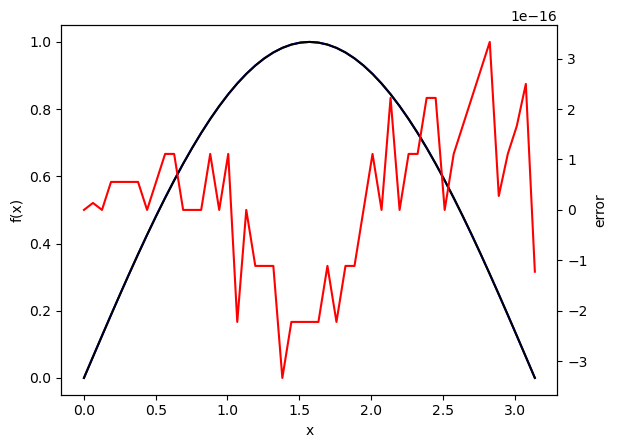

In [31]:
f = guess(x)
m = N//2
fleft = f[0:m+1]
fright = f[m-1:]

for iter in range(nstep):
    fright = euler(fright, dt, h)
    fleft = euler(fleft, dt, h)
    fleft[-1] = fright[1]
    fright[0] = fleft[-2]

f = np.concatenate((fleft[:-1],fright[1:]))
doplot(f, x)

**Third,** make it run in parallel using just two processes.
* We make a new process and number the two processes
  * The original process is `id=0`
  * The new process is `id=1`
* Process `0` will simulate the left and process `1` the right
* When we start the new process we pass `id,dt,h,fright`
* Each process iterates, exchanging data each time step
* When finished, process `1` sends the solution `fright` process `0`

*N.B.:* When exchanging the data process 0 does send then receive but process 1 does receive then send.  Why?

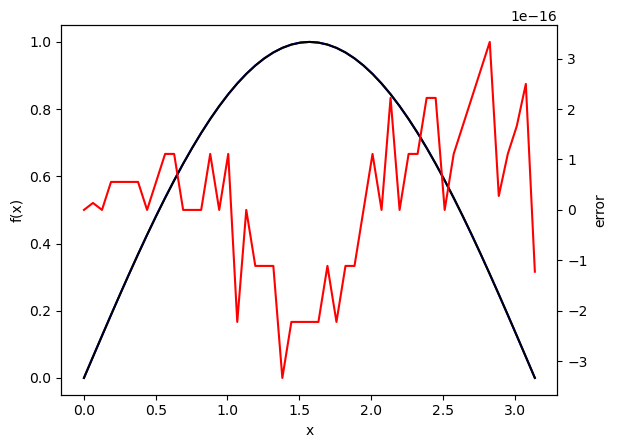

In [32]:
def solve(conn, id, dt, h, nstep, f):
    for step in range(nstep):
        f = euler(f, dt, h)
        if id == 0:
            f[-1] = conn.recv()
            conn.send(f[-2])
        else:
            conn.send(f[1])
            f[0] = conn.recv()

    if id == 0:
        fright = conn.recv()
        return np.concatenate((f[:-1],fright[1:]))
    else:
        conn.send(f)
        conn.close()

f = guess(x)
m = N//2
fleft = f[0:m+1]
fright = f[m-1:]

parent_conn, child_conn = mp.Pipe()
p = mp.Process(target=solve, args=(child_conn, 1, dt, h, nstep, fright))
p.start()
f = solve(parent_conn, 0, dt, h, nstep, fleft) 
p.join()

doplot(f, x)